In [2253]:
import pandas as pd
import numpy as np
import json 
import math
import statistics
from scipy.stats import ttest_ind
from scipy.stats import levene
from scipy.stats import mannwhitneyu

import seaborn as sns
import pprint as p
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm
import warnings

from matplotlib_venn import venn2
from pandas.plotting import parallel_coordinates
from matplotlib import rcParams
from sklearn.metrics import pairwise_distances
from functions import *

csfont = {'fontname':'Times New Roman'}
hfont = {'fontname':'Helvetica'}
prop = fm.FontProperties(fname='/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf')
mpl.rc('font',family='Times New Roman')
class color:
   PURPLE, CYAN, DARKCYAN, BLUE = '\033[95m', '\033[96m', '\033[36m', '\033[94m'
   GREEN, YELLOW, RED, BOLD = '\033[92m', '\033[93m', '\033[91m','\033[1m'
   UNDERLINE, END = '\033[4m','\033[0m'
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2254]:
df = pd.read_csv('CleanData/HSS_lf.csv', sep=';')
q_data = pd.read_csv('CleanData/Q_df.csv', sep=';')
customization_data = pd.read_csv('CleanData/Customization.csv', sep=';')
q_data = q_data.drop(columns='Unnamed: 0')
q_data = q_data.drop_duplicates(subset='UserID', keep='last')

In [2255]:
df = df.iloc[:, ~df.columns.isin(customization_data.columns)]
p.pp(df.columns.tolist())

['UserID',
 'totalAnnotatedGraffiti',
 'storyProgress',
 'x',
 'y',
 'z',
 'rotation',
 'level',
 'crystals',
 'battery',
 'exp',
 'maxexp',
 'soap',
 'rocket',
 'glider',
 'dialogueIndex',
 'graffitiTutorial',
 'dialogueTutorial',
 'annotatedGraffitiIndeces',
 'saveableObjects',
 'friends',
 'dialoguesFinished',
 'graffitiFinished',
 'likes',
 'annData',
 'GameTime',
 'GraffitiTime',
 'DialogueTime',
 'NumberOfGraffitiActivated',
 'NumberOfAnnotatedGraffiti',
 'NumberOfDialoguesActivated',
 'NumberOfAnnotatedSentences']


####  Users identified between HSS data and questionnaire data

In [2256]:
df = df.drop_duplicates(subset='UserID', keep='last')

HSS sample of users: 428
Questionnaire sample of users: 358


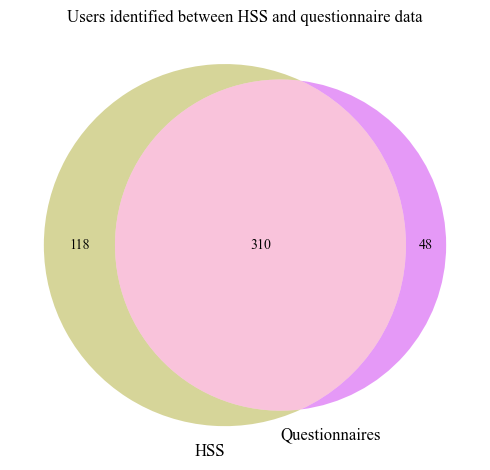

Only users with questionnaire data will be considered for this analysis.


In [2257]:
print(f"HSS sample of users: {df.UserID.unique().shape[0]}")
print(f"Questionnaire sample of users: {q_data.UserID.unique().shape[0]}")
figure, ax = plt.subplots(1, 1, figsize=[5, 5])
set1 = set(df.UserID.tolist())
set2 = set(q_data.UserID.tolist())
venn_labels = {'10': f'Total Set 1: {len(set1)}', '01': f'Total Set 2: {len(set2)}'} 
venn2(subsets=(len(set1 - set2), len(set2 - set1), len(set1.intersection(set2))),
      set_labels=('HSS', 'Questionnaires'), set_colors=('#999600', '#be00ed'))
plt.tight_layout()
plt.title('Users identified between HSS and questionnaire data')
plt.savefig("Graphs/venndiagram.pdf", dpi=1000)
plt.show()
print('Only users with questionnaire data will be considered for this analysis.')
df = df[df.UserID.isin(set1.intersection(set2))]
q_data = q_data[q_data.UserID.isin(set1.intersection(set2))]

In [2258]:
df.describe().iloc[1:,:12]

,totalAnnotatedGraffiti,storyProgress,x,y,z,level,crystals,battery,exp,maxexp,soap,dialogueIndex
mean,5.029032,0.080645,156.097991,1.007809,31.389538,1.683871,59.848387,3.929032,48.874194,114.170968,50.335484,8.238710
std,3.740247,0.272730,152.035443,1.004343,104.831589,1.124915,48.505559,2.783701,47.392873,55.572104,34.124136,10.342099
min,0.000000,0.000000,-93.179375,0.163810,-181.402756,1.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000
25%,2.000000,0.000000,9.850763,0.840243,-58.636710,1.000000,22.000000,1.000000,16.250000,100.000000,21.000000,1.000000
50%,4.000000,0.000000,176.844086,0.894150,13.590336,1.000000,50.000000,5.000000,41.000000,100.000000,50.500000,5.500000
75%,7.000000,0.000000,234.561676,0.900559,105.116365,2.000000,89.000000,7.000000,78.750000,108.000000,78.000000,11.000000
max,22.000000,1.000000,629.775635,11.719266,814.857300,9.000000,274.000000,7.000000,566.000000,829.000000,100.000000,75.000000


In [2259]:
df.describe().iloc[1:,12:]

,friends,likes,GameTime,GraffitiTime,DialogueTime,NumberOfGraffitiActivated,NumberOfAnnotatedGraffiti,NumberOfDialoguesActivated,NumberOfAnnotatedSentences
mean,0.829032,124.338710,943.227738,589.418492,580.827603,9.419355,7.458065,18.835484,9.348387
std,1.160207,194.989714,370.937470,509.632637,908.858772,7.559791,6.102404,16.776719,14.171668
min,0.000000,0.000000,15.470000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,723.716278,283.453827,167.090752,4.000000,3.000000,8.000000,1.000000
50%,0.000000,83.000000,904.639465,445.622513,333.637039,8.000000,6.000000,15.000000,6.000000
75%,2.000000,161.500000,1137.298950,760.664612,679.939301,12.000000,10.000000,25.750000,11.000000
max,7.000000,2449.000000,2388.364258,3457.448486,9566.537109,66.000000,40.000000,144.000000,129.000000


In [2260]:
df['friends'] = df['friends'].astype(int)

In [2261]:
print(df.dtypes)

UserID                         object
totalAnnotatedGraffiti          int64
storyProgress                   int64
x                             float64
y                             float64
z                             float64
rotation                       object
level                           int64
crystals                        int64
battery                         int64
exp                           float64
maxexp                        float64
soap                          float64
rocket                           bool
glider                           bool
dialogueIndex                   int64
graffitiTutorial                 bool
dialogueTutorial                 bool
annotatedGraffitiIndeces       object
saveableObjects                object
friends                         int64
dialoguesFinished              object
graffitiFinished               object
likes                         float64
annData                        object
GameTime                      float64
GraffitiTime

### The Typical Gameplay
In this section I try to describe the typical behaviour. It is broken down into: 

- annotation data actions, which represents how many times the user interacted with dialogue and graffiti
- saveable objects, which is about the objects that are taken 

In [2262]:
df[~pd.isnull(df.annData)].shape[0]

310

In [2263]:
annData = []
saveableObjects = []
for el in range(df[~pd.isnull(df.annData)].shape[0]):
    buggy_string = df.iloc[el].annData
    l = json.loads(df.iloc[el].annData.replace("'", '"').replace('inf', '0')) 
    annData.append(pd.DataFrame.from_dict(l))
    buggy_string = df.iloc[el].saveableObjects
    l = json.loads(df.iloc[el].saveableObjects.replace("'", '"').replace('inf', '0').replace('True', '1')) 
    saveableObjects.append(pd.DataFrame.from_dict(l))

In [2264]:
df['annData'] = annData 
df['saveableObjects'] = saveableObjects

In [2265]:
# df['saveableObjects'].iloc[53]#['id']
df['annData'].iloc[49]#['id']

,id,timePerToken,type
0,7449,1.114300,graffiti
1,7443,0.293286,graffiti
2,7445,0.498857,graffiti
3,7444,1.350250,graffiti


In [2266]:
Dialogue_avgt = []
Graffiti_avgt = []
for user in range(df.shape[0]):
    try:
        Dialogue_avgt.append(df.iloc[user].annData[df.iloc[user].annData.type=='dialogue'].timePerToken.median())
        Graffiti_avgt.append(df.iloc[user].annData[df.iloc[user].annData.type=='graffiti'].timePerToken.median())
    except AttributeError:
        Dialogue_avgt.append(0)
        Graffiti_avgt.append(0)
df['Dialogue_avgt'] = Dialogue_avgt
df['Graffiti_avgt'] = Graffiti_avgt

#### Mean vs Median for time spent on graffiti and dialogues
Is the mean a good summary statistic to represent the time spent of removing graffiti and the time spent in dialogues? To answer, I compare the regularized distribution (the averages of all users actions) with the original distribution.  

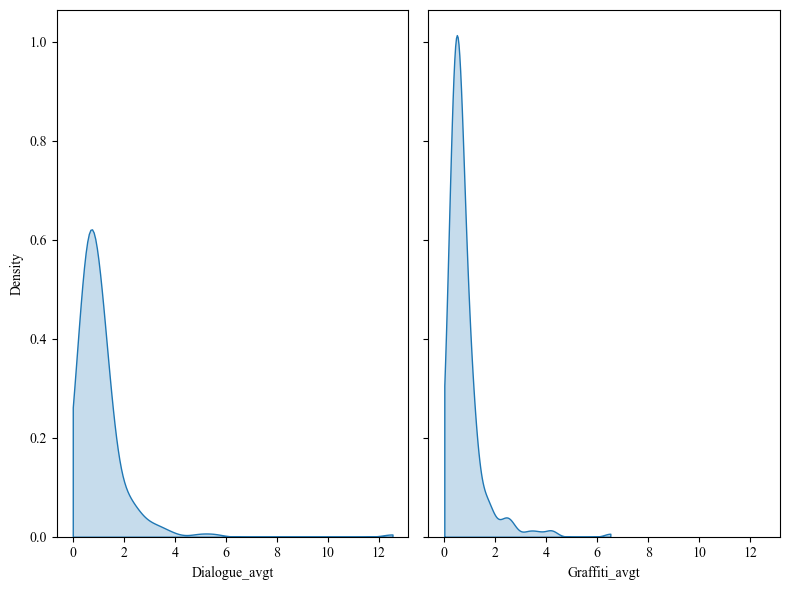

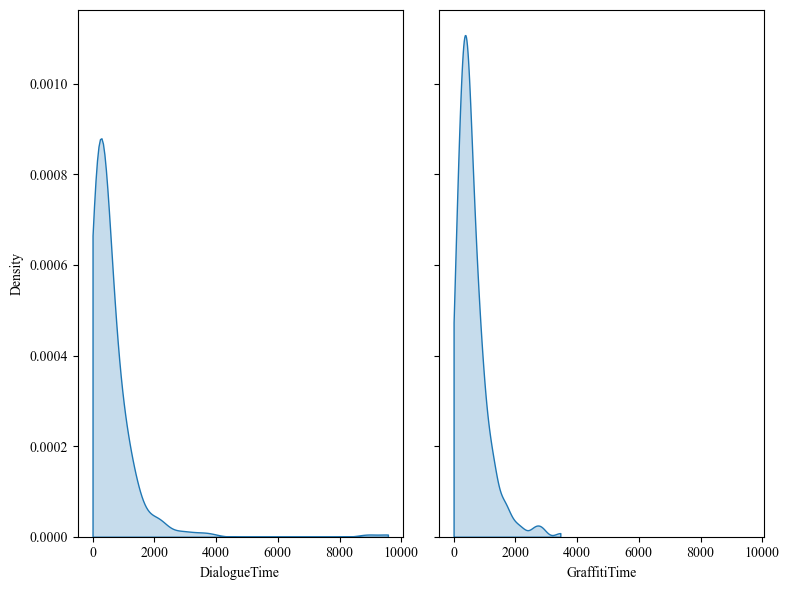

In [2267]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6), sharey=True, sharex=True) 

sns.kdeplot(df.Dialogue_avgt, cut=0, fill=True, ax=axs[0])
sns.kdeplot(df.Graffiti_avgt, cut=0, fill=True, ax=axs[1])
plt.tight_layout()
fig, axs = plt.subplots(1, 2, figsize=(8, 6), sharey=True, sharex=True) 
sns.kdeplot(df.DialogueTime, cut=0, fill=True, ax=axs[0])
sns.kdeplot(df.GraffitiTime, cut=0, fill=True, ax=axs[1])
plt.tight_layout()
plt.show()

It appears that the shape of the distributions is relatively intact. It also seems to skew less to the right, which is what is needed as many outliers are present. As a final comparison, mean vs median, but it doesn't seem to differ much. 

In [2268]:
# Dialogue_avgt = []
# Graffiti_avgt = []
# for user in range(df.shape[0]):
#     try:
#         Dialogue_avgt.append(df.iloc[user].annData[df.iloc[user].annData.type=='dialogue'].timePerToken.median())
#         Graffiti_avgt.append(df.iloc[user].annData[df.iloc[user].annData.type=='graffiti'].timePerToken.median())
#     except AttributeError:
#         Dialogue_avgt.append(0)
#         Graffiti_avgt.append(0)
# df['Dialogue_avgt'] = Dialogue_avgt
# df['Graffiti_avgt'] = Graffiti_avgt

# fig, axs = plt.subplots(2, 2, figsize=(8, 6)) 

# sns.kdeplot(df.Dialogue_avgt, cut=0, fill=True, ax=axs[0, 0])
# sns.kdeplot(df.Graffiti_avgt, cut=0, fill=True, ax=axs[0, 1])
# sns.kdeplot(df.DialogueTime, cut=0, fill=True, ax=axs[1, 0])
# sns.kdeplot(df.GraffitiTime, cut=0, fill=True, ax=axs[1, 1])
# plt.tight_layout()
# plt.show()

In [2269]:
g_data = pd.DataFrame({'Dialogue_avgt':df.Dialogue_avgt.tolist(), 'Graffiti_avgt':df.Graffiti_avgt, 'DialogueTime':df.DialogueTime})
g_data['Gender'] = [gender if "Preferisco non rispondere" else 'NA' for gender in q_data.Gender]
print(g_data.Gender.value_counts())
g_data['Age'] = [age for age in q_data['Age']]

Gender
Maschio                      177
Femmina                      110
Preferisco non rispondere     22
Name: count, dtype: int64


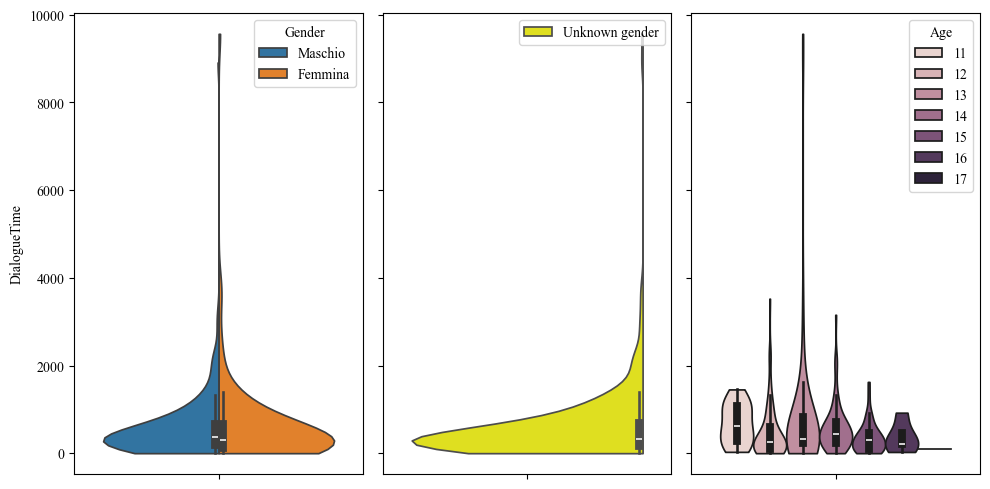

In [2270]:
fig, axs = plt.subplots(1,3, figsize=(10, 5), sharey=True, sharex=True) 
sns.violinplot(data=g_data[g_data['Gender'] != "Preferisco non rispondere"], y='DialogueTime', cut=0, fill=True, hue = 'Gender', split=True, ax=axs[0])
sns.violinplot(data=g_data, y='DialogueTime', cut=0, fill=True, ax=axs[1], label='Unknown gender', split=True, color='#FFFF00')
sns.violinplot(data=g_data, y='DialogueTime', cut=0, fill=True, hue='Age', ax=axs[2])
plt.tight_layout()
plt.show()

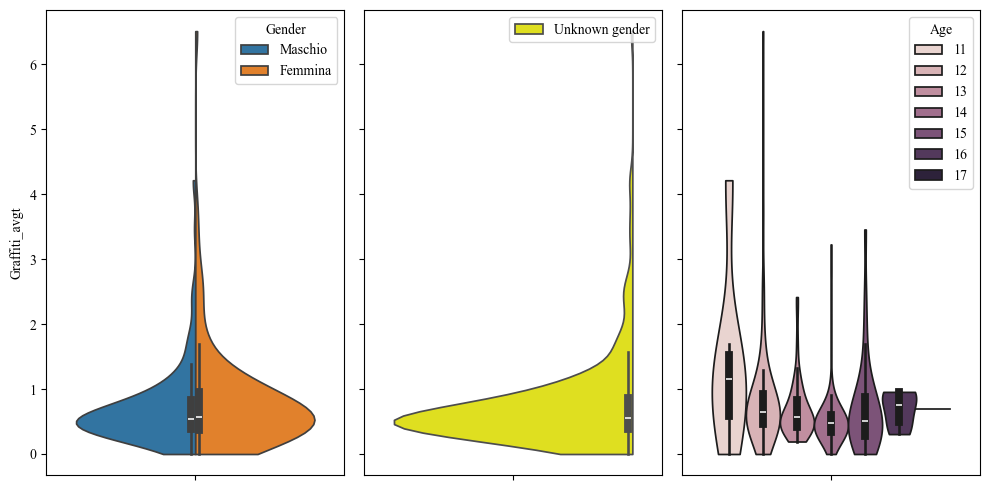

In [2271]:
fig, axs = plt.subplots(1,3, figsize=(10, 5), sharey=True, sharex=True) 
sns.violinplot(data=g_data[g_data['Gender'] != "Preferisco non rispondere"], y='Graffiti_avgt', cut=0, fill=True, hue = 'Gender', split=True, ax=axs[0])
sns.violinplot(data=g_data, y='Graffiti_avgt', cut=0, fill=True, ax=axs[1], label='Unknown gender',split=True, color='#FFFF00')
sns.violinplot(data=g_data, y='Graffiti_avgt', cut=0, fill=True, hue='Age', ax=axs[2])
plt.tight_layout()
plt.show()

In [2272]:
df.friends.value_counts()

friends
0    175
2     56
1     53
3     18
4      5
6      1
7      1
5      1
Name: count, dtype: int64

In [2273]:
df.to_csv('HSS_for_FB.csv', sep=';')

#### Sequential pattern mining

In [2274]:
import pandas as pd
from prefixspan import PrefixSpan

In [2275]:
l_pat = []

for dataframe in range(df.annData.shape[0]):
    
    try: 
        l = df.annData.iloc[dataframe].type.tolist()
    except AttributeError:
        l = []
    l_pat.append(l)

In [2276]:
ps = PrefixSpan(l_pat)
patterns = ps.topk(10) 
for pattern in patterns:
    print(f"Pattern: {pattern[1]}, Support: {pattern[0]}")

Pattern: ['graffiti'], Support: 278
Pattern: ['graffiti', 'graffiti'], Support: 258
Pattern: ['graffiti', 'graffiti', 'graffiti'], Support: 239
Pattern: ['dialogue'], Support: 232
Pattern: ['graffiti', 'graffiti', 'graffiti', 'graffiti'], Support: 211
Pattern: ['dialogue', 'dialogue'], Support: 206
Pattern: ['graffiti', 'dialogue'], Support: 194
Pattern: ['dialogue', 'dialogue', 'dialogue'], Support: 191
Pattern: ['graffiti', 'graffiti', 'graffiti', 'graffiti', 'graffiti'], Support: 182
Pattern: ['dialogue', 'dialogue', 'dialogue', 'dialogue'], Support: 179


In [2277]:
l_pat = []

for dataframe in range(df.saveableObjects.shape[0]):
    
    try: 
        l = df.saveableObjects.iloc[dataframe].name.tolist()
    except AttributeError:
        l = []
    l_pat.append(l)
ps = PrefixSpan(l_pat)
patterns = ps.topk(5)

for pattern in patterns:
    print(f"Pattern: {pattern[1]}, Support: {pattern[0]}")

Pattern: ['ChestNoKey (23)Lid'], Support: 48
Pattern: ['ChestNoKey (26)Lid'], Support: 35
Pattern: ['BedroomSmartphone'], Support: 23
Pattern: ['BedroomSmartphone', 'TriggerArea1'], Support: 23
Pattern: ['TriggerArea1'], Support: 23


#### The "bug-finders"
There are a few ways to play the game to level up faster. One of them is a specific way to play the dialogue option, and the other is analogous to graffiti erasing. 
During data collection, I noticed this while observing that some users, while playing, identified a way to play faster through spamming the dialogue option buttons, which would augment the school safety and other stats. 

Some of them weren't probably actively looking for a bugged feature, but simply looking forward to "max" some of their in-game statistics; even then, their game experience represent a relevant category of students in this secondary analysis experiment. 

Let's find out how many of them were doing so by visualizing the distribution of dialogue and graffiti actions, comparing the amount of actions and the time spent on them.

In [2278]:
df.columns.tolist()

['UserID',
 'totalAnnotatedGraffiti',
 'storyProgress',
 'x',
 'y',
 'z',
 'rotation',
 'level',
 'crystals',
 'battery',
 'exp',
 'maxexp',
 'soap',
 'rocket',
 'glider',
 'dialogueIndex',
 'graffitiTutorial',
 'dialogueTutorial',
 'annotatedGraffitiIndeces',
 'saveableObjects',
 'friends',
 'dialoguesFinished',
 'graffitiFinished',
 'likes',
 'annData',
 'GameTime',
 'GraffitiTime',
 'DialogueTime',
 'NumberOfGraffitiActivated',
 'NumberOfAnnotatedGraffiti',
 'NumberOfDialoguesActivated',
 'NumberOfAnnotatedSentences',
 'Dialogue_avgt',
 'Graffiti_avgt']

In [2279]:
df.annData.iloc[1][df.annData.iloc[1].type=='graffiti'].timePerToken.sum()
df.GraffitiTime.iloc[1]

335.9919738769531

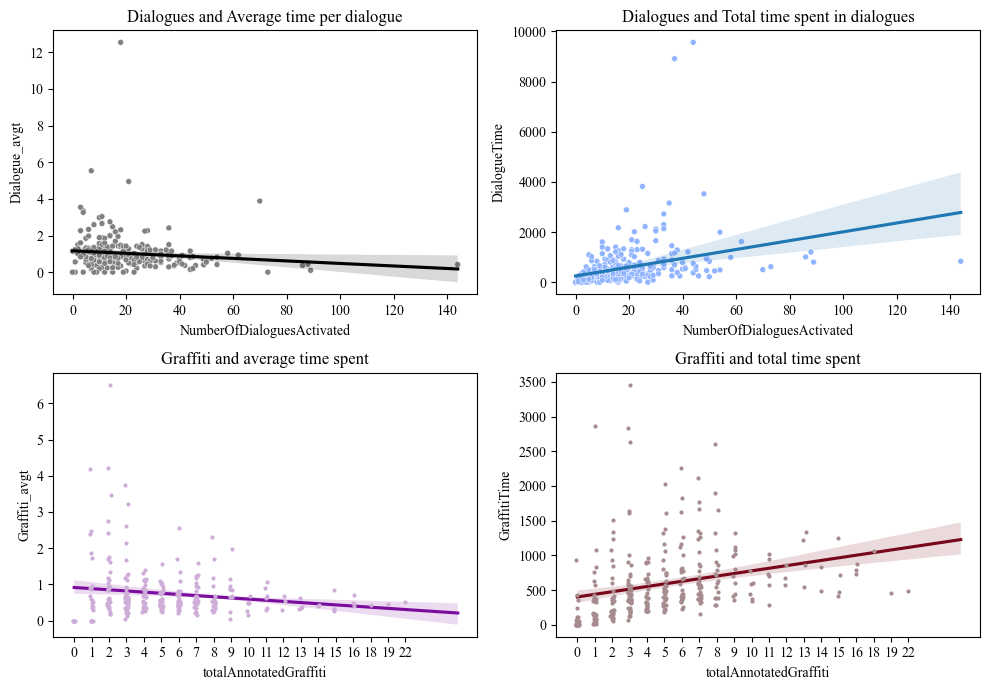

In [2280]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7)) 
axs[0, 0].set_title('Dialogues and Average time per dialogue')
sns.scatterplot(data=df, x='NumberOfDialoguesActivated', y='Dialogue_avgt', ax=axs[0,0], color='grey', size=2, legend=False)
sns.regplot(data=df, x='NumberOfDialoguesActivated', y='Dialogue_avgt', ax=axs[0,0], color='black', scatter=False)

axs[0, 1].set_title('Dialogues and Total time spent in dialogues')
sns.scatterplot(data=df, x='NumberOfDialoguesActivated', y='DialogueTime', ax=axs[0, 1], color = '#91b4ff', size=2, legend=False)
sns.regplot(data=df, x='NumberOfDialoguesActivated', y='DialogueTime', ax=axs[0, 1], scatter=False)

axs[1, 0].set_title('Graffiti and average time spent')
# sns.scatterplot(data=df, x='totalAnnotatedGraffiti', y='Graffiti_avgt', ax=axs[1, 0], color= '#ceadd9', size=2, legend=False, jitter=True)
sns.stripplot(data=df, x='totalAnnotatedGraffiti', y='Graffiti_avgt', ax=axs[1, 0], color= '#ceadd9', size=3, legend=False, jitter=True, edgecolor='white')
sns.regplot(data=df, x='totalAnnotatedGraffiti', y='Graffiti_avgt', ax=axs[1,0], color='#7a0d9e', scatter=False)

axs[1, 1].set_title('Graffiti and total time spent')
# sns.scatterplot(data=df, x='totalAnnotatedGraffiti', y='GraffitiTime', ax=axs[1, 1], color='#a68b8f', size=2, legend=False)
sns.stripplot(data=df, x='totalAnnotatedGraffiti', y='GraffitiTime', ax=axs[1, 1], color= '#a68b8f', size=3, legend=False, jitter=True, edgecolor='white')
sns.regplot(data=df, x='totalAnnotatedGraffiti', y='GraffitiTime', ax=axs[1, 1], color='#780819', scatter=False)

plt.tight_layout()
plt.savefig('Graphs/Dialogues_and_time_BugFinders.png',dpi=500)
plt.show()

One would expect the relationship between time spent and number of dialogues activate to be somewhat linear. The more dialogues a person interacts with, the less time it can take them because they're learning how to play the game faster. On the other hand, users who don't spend much time on removing graffiti or changing dialogues, should spend more time - on average - per action. It is kind of true when we look at the average time distributions and the regression, it's a slightly negative relationship, although only slightly and **is definitely skewed by outliers**. Most users spent little time per graffiti and dialogue. 

Let's try to find users who stand out - in both ways, as in excelling or underperforming - with gameplay features.

In [2281]:
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from colour import Color
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

In [2282]:
cols = ['totalAnnotatedGraffiti','storyProgress','level', 'crystals', 
 'battery','exp', 'maxexp', 'soap', 'rocket', 'glider','dialogueIndex', 'dialoguesFinished',
 'graffitiFinished', 'friends', 'likes', 'GameTime','NumberOfGraffitiActivated',
        'NumberOfAnnotatedGraffiti','NumberOfDialoguesActivated',
        'NumberOfAnnotatedSentences', 'Dialogue_avgt', 'Graffiti_avgt']

treating feature totalAnnotatedGraffiti...
treating feature storyProgress...
treating feature level...
treating feature crystals...
treating feature battery...
treating feature exp...
treating feature maxexp...
treating feature soap...
treating feature rocket...
treating feature glider...
treating feature dialogueIndex...
treating feature dialoguesFinished...
treating feature graffitiFinished...
treating feature friends...
treating feature likes...
treating feature GameTime...
treating feature NumberOfGraffitiActivated...
treating feature NumberOfAnnotatedGraffiti...
treating feature NumberOfDialoguesActivated...
treating feature NumberOfAnnotatedSentences...
treating feature Dialogue_avgt...
treating feature Graffiti_avgt...


<Axes: >

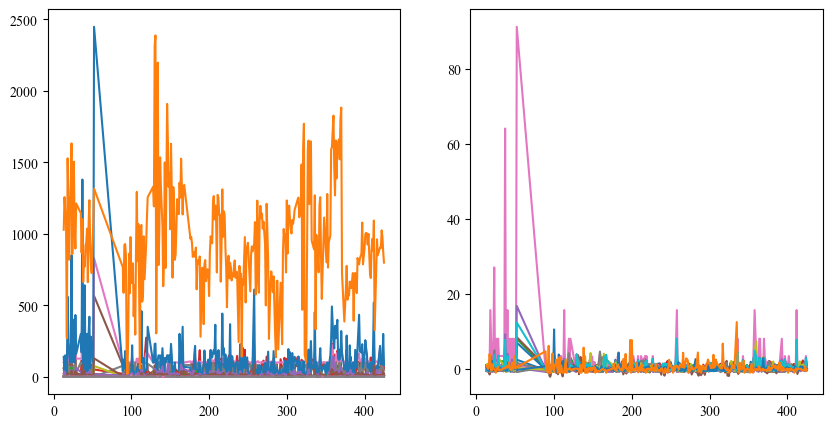

In [2283]:
cl_df = df[cols].copy(deep=True)
fig, axs =  plt.subplots(1,2, figsize=(10, 5)) 
cl_df.plot(legend=False, ax=axs[0])
for c in cols:
    print(f'treating feature {c}...')
    # print(f'{c}, {cl_df[c].isna().value_counts()}')
    if cl_df[c].isna().value_counts().shape[0] > 1:
        #fill missing values or nan with 0 (according to internship tutor)
        cl_df[c] = cl_df[c].fillna(0).copy(deep=True)
        #now we scale the variables
    cl_df[c] = RobustScaler().fit_transform(cl_df[[c]])
cl_df.columns
        
cl_df.plot(legend=False, ax=axs[1])

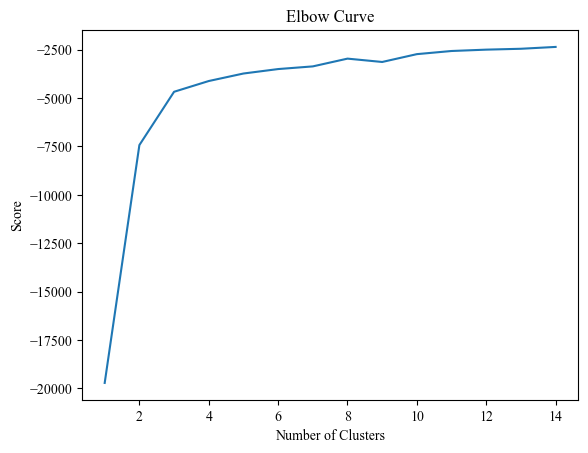

In [2284]:
num_clusters = 15
kmeans_tests = [KMeans(n_clusters=i, init='random', n_init=10) for i in range(1, num_clusters)]
score = [kmeans_tests[i].fit(cl_df).score(cl_df) for i in range(len(kmeans_tests))]

# Plot the curve
plt.plot(range(1, num_clusters),score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

The K, as in many cases, is around 3. In the following cells I will try 3 and 5. 

In [2285]:
K = 3

kmeans = KMeans(n_clusters=K, random_state=25)
        
cl_df['cluster'] = kmeans.fit_predict(cl_df)

colors = ['#5b7fbf', '#ffef66', '#f0800e']
cmap_custom = ListedColormap(colors)

g = cl_df
pca = PCA(n_components=3)

reduced_features = pca.fit_transform(cl_df)

reduced_g = pd.DataFrame(reduced_features, index=g.index, columns=['PC1','PC2', 'PC3'])
reduced_g['labels'] = cl_df['cluster'].copy(deep=True)
# xdata = reduced_g['PC1']
xdata = reduced_g['PC1']
ydata = reduced_g['PC2']
zdata = reduced_g['PC3']

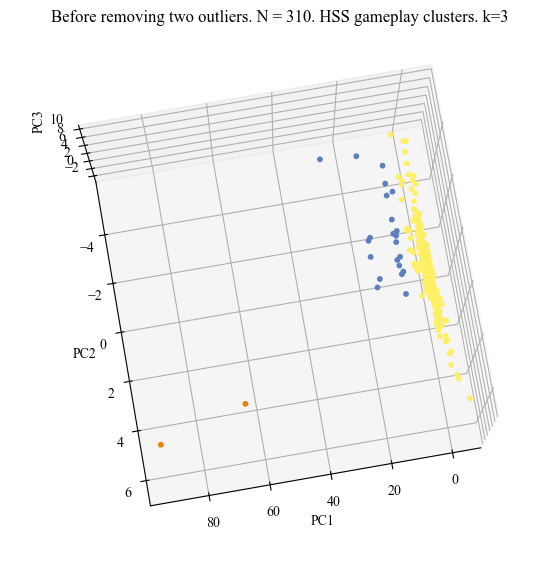

In [2286]:
colors = ['#ffef66', '#f0800e', '#5b7fbf']
cmap_custom = ListedColormap(colors)

g = cl_df
pca = PCA(n_components=3)

reduced_features = pca.fit_transform(g)

reduced_g = pd.DataFrame(reduced_features, index=g.index, columns=['PC1','PC2', 'PC3'])
reduced_g['cluster'] = g.cluster

xdata = reduced_g['PC1']
ydata = reduced_g['PC2']
zdata = reduced_g['PC3']

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(xdata, ydata, zdata, c=reduced_g['cluster'], cmap=cmap_custom, s=10, alpha=1)

ax.view_init(elev=80, azim=80)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3', rotation = 90)
plt.title(f'Before removing two outliers. N = {reduced_g.shape[0]}. HSS gameplay clusters. k={K}')

plt.savefig("Graphs/BugFindersclustered.png", dpi=500)
plt.show()

There are two users who are extremely different than the others, and take up as much as one whole cluster due to their distance.

##### That one outlier
(very short analysis to compare the most extreme observation with the average feature value)

In [2287]:
user = df[xdata > 80] #the most extreme observation

The index matches the ID of the user. The user's ID is:  ['t43-user19']

Features by which user 52    t43-user19
Name: UserID, dtype: object is above average: (mean of the feature < value of the user)
	    σ        x̄
totalAnnot:3.74    5.03 <  16.00
__________
	    σ        x̄
level:     1.12    1.68 <  9.00
__________
	    σ        x̄
battery:   2.78    3.93 <  6.00
__________
	    σ        x̄
exp:       47.39   48.87 < 566.00
__________
	    σ        x̄
maxexp:    55.57   114.17 < 829.00
__________
	    σ        x̄
rocket:    0.29    0.09 <  1.00
__________
	    σ        x̄
glider:    0.20    0.04 <  1.00
__________
	    σ        x̄
dialogueIn:10.34   8.24 <  75.00
__________
	    σ        x̄
dialoguesF:0.15    0.02 <  1.00
__________
	    σ        x̄
graffitiFi:0.37    0.16 <  1.00
__________
	    σ        x̄
friends:   1.16    0.83 <  2.00
__________
	    σ        x̄
likes:     194.99  124.34 < 2449.00
__________
	    σ        x̄
GameTime:  370.94  943.23 < 1316.48
__________
	   

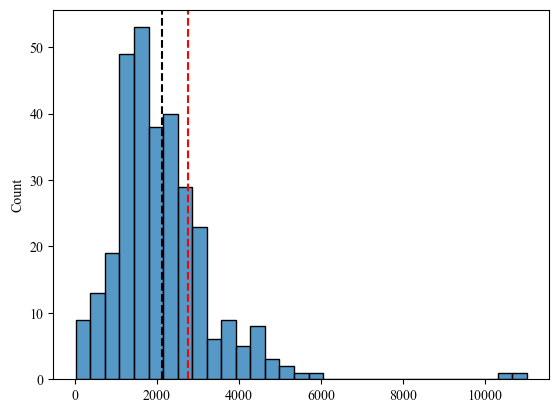

Average game time: 35 minutes and 13 seconds (black line)
The outlier's game time: 46 minutes and 1 seconds (red line)


In [2288]:
print('The index matches the ID of the user. The user\'s ID is: ', user.UserID.tolist())
print()
print(f'Features by which user {user.UserID} is above average: (mean of the feature < value of the user)')
for c in cols:
    if user[c].iloc[0] > df[c].mean():
        sigma = float(df[c].std())
        mean = df[c].mean()
        usrvalue = user[c].iloc[0]
        
        if len(c) <= 10:
            pad1 = (10-len(c))*' '
            cprint = c
            
        else:
            cprint = c[:10]
            pad1 = ''
        pad2 = (8-len(f'{sigma:.2f}'))*' '
        pad3 = (5-len(f'{mean:.2f}'))*' '
        print(f'\t    σ {' '*7}x̄')
        print(f'{cprint}:{pad1}{sigma:.2f}{pad2}{mean:.2f} < {pad3}{usrvalue:.2f}')
        print('__________')
sns.histplot(T)
plt.axvline(T.mean(), color='black', linestyle='--')
plt.axvline((user.GameTime.iloc[0] + user.GraffitiTime.iloc[0] + user.DialogueTime.iloc[0]).mean(), color='red',  linestyle='--')
plt.show()
T = (df.GameTime + df.GraffitiTime + df.DialogueTime)
print(f'Average game time: {int(T.mean()//60)} minutes and {round(T.mean()%60)} seconds (black line)')

print(f'The outlier\'s game time: {int((user.GameTime.iloc[0] + user.GraffitiTime.iloc[0] + user.DialogueTime.iloc[0])//60)} minutes and {round((user.GameTime.iloc[0] + user.GraffitiTime.iloc[0] + user.DialogueTime.iloc[0])%60)} seconds (red line)')

In [2289]:
 #The outliers can be removed with the following code.
outliers = df[df.index.isin(cl_df.index)][xdata > 60] # Both of the most extreme observations
cl_df = cl_df[~df.UserID.isin(outliers.UserID)]

### Visualizing the clusters
Minus the two outlier that could make an entire cluster by themselves.
K is now 5 due to a better visual representation of the clusters. It is very unlikely on real, small, social data to have perfectly separable clusters, but we try.

In [2291]:
outliers = df[df.index.isin(cl_df.index)][xdata > 20]
cl_df = cl_df[~df[df.index.isin(cl_df.index)].UserID.isin(outliers.UserID)]

/tmp/ipykernel_23714/139056906.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [2374]:
K = 5

kmeans = KMeans(n_clusters=K, random_state=25, verbose=1)
        
cl_df['cluster'] = kmeans.fit_predict(cl_df.iloc[:, :-1])  #minus the cluster feature

colors = ['#5b7fbf', '#ffef66', '#f0800e']
cmap_custom = ListedColormap(colors)

g = cl_df.copy(deep=True)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=g.iloc[1:2, :-1].columns)
g_withcenters = pd.concat([g, pd.DataFrame(kmeans.cluster_centers_, columns=g.iloc[1:2, :-1].columns)], axis=0)
g_withcenters.iloc[-5:, -1] = [0, 1, 2, 3, 4]
pca = PCA(n_components=3)

reduced_features = pca.fit_transform(g)

reduced_g = pd.DataFrame(reduced_features[:-5], index=g.iloc[:-5, :].index, columns=['PC1','PC2', 'PC3'])
reduced_g['cluster'] = g.iloc[:,-1]

xdata = reduced_g['PC1']
ydata = reduced_g['PC2']
zdata = reduced_g['PC3']

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=xdata, y=ydata, z=zdata, mode='markers', marker=dict(color=reduced_g['cluster'], colorscale=colors, size=5)))
fig.add_trace(go.Scatter3d(x=reduced_features[-5:, 0], y=reduced_features[-5:, 1], z=reduced_features[-5:, 2],
                           mode='markers', marker=dict(color='black', size=10)))

fig.update_layout(scene=dict(
    xaxis_title='PC1',
    yaxis_title='PC2',
    zaxis_title='PC3'
), width=800, height=800)

# Show the plot
fig.show()

Initialization complete
Iteration 0, inertia 4642.034648890207.
Iteration 1, inertia 3430.873131482025.
Iteration 2, inertia 3121.2255280896748.
Iteration 3, inertia 2977.5205516312794.
Iteration 4, inertia 2964.868903781963.
Iteration 5, inertia 2960.1678450315053.
Iteration 6, inertia 2954.5835252073944.
Iteration 7, inertia 2954.3224293090548.
Iteration 8, inertia 2953.9895728090414.
Iteration 9, inertia 2953.656143017445.
Iteration 10, inertia 2953.539228155506.
Converged at iteration 10: strict convergence.


In [2293]:
centroids = kmeans.cluster_centers_
distance_from_centroid = []
for u in range(cl_df.cluster.shape[0]):
    cl = int(cl_df.iloc[u,:].cluster.tolist())

    d = pairwise_distances([cl_df.iloc[u,:-1].tolist()], [kmeans.cluster_centers_[cl]], metric='euclidean')
    distance_from_centroid.append(d[0][0])

In [2294]:
dist_df = pd.DataFrame(cl_df['cluster'])
dist_df['distances'] = distance_from_centroid
for cluster in pd.Series(dist_df.cluster.unique()).sort_values(ascending=True):
    print(f'For cluster {cluster}, mean distance from cluster centroid is {dist_df[dist_df['cluster'] == cluster].distances.median():.2f}')

For cluster 0, mean distance from cluster centroid is 2.34
For cluster 1, mean distance from cluster centroid is 4.66
For cluster 2, mean distance from cluster centroid is 2.24
For cluster 3, mean distance from cluster centroid is 2.91
For cluster 4, mean distance from cluster centroid is 3.03


We have a "winner"! Users from cluster 2 (scale of clusters is 0 - 2, so the third cluster) are significantly different from each other, as the **median** distance from the identified cluster centroid indicates, indicating that these users spent their time trying to get higher stats in one or more specific features. 

But they're not only different from each other, but they're obviously different from the other clusters as well. The same information is displayed in the PCA, where cluster 2 is scoring higher on the first Principal Component (PC1), and is always more sparse in PC2 and PC3 than the other, denser, clusters. 

### Cluster analysis, visualization and associations
Using correlation, we highlight the features that are highly correlated with belonging to specific clusters.
In this section I reintroduce the two outliers that were excluded for visualization purposes.

First, I answer which variables are strongly correlated with clusters. 
Second, I use the Recursive Feature Elimination method to find a model with the best goodness of fit for a simple linear regression model. 

In [2295]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

Individual correlation (feature -> cluster):
Keep in mind: these correlations indicate the correlation of a feature to a cluster feature that has values between [0, 1, 2];
Clusters are artificially constructed categories that are ordered on several features.


Interpretation:
For example, since Dialogue index is highly correlated with "clusters" we can read it as users from cluster 0 have a lower amount of GameTime, while
users of cluster 2 have a higher amount. And the strength of correlation indicates how much a unit change of GameTime is correlated with a cluster change in the data.


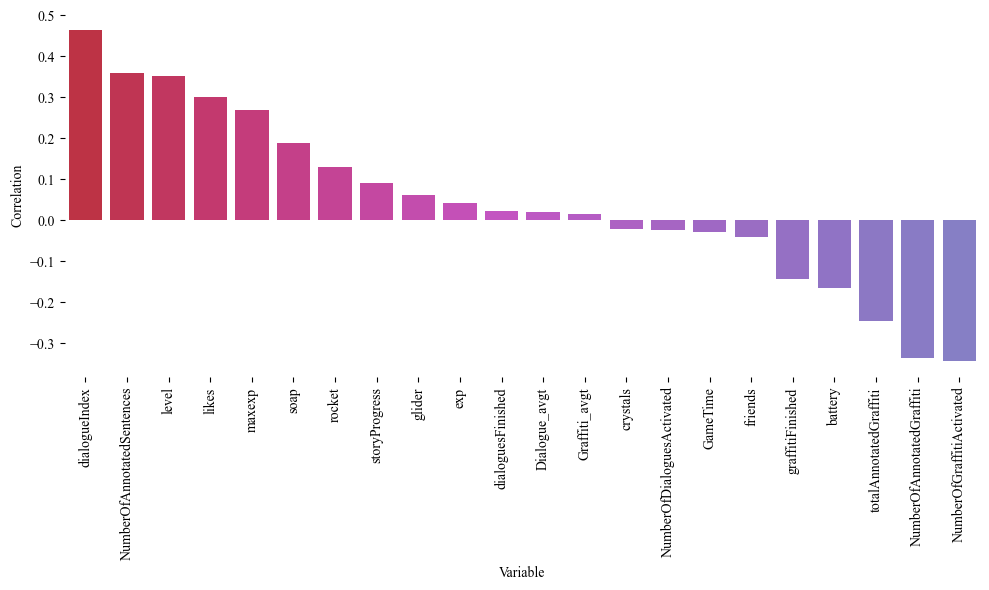

In [2322]:
#A good correlation analysis shouldn't differ in its values if the variables are standardized or not, 
#because linear correlation is defined as the scaled covariance of (in our case) two variables. I wanted to try out the standard scaler from sklearn. 
#"Pearson's correlation coefficient is the covariance of the two variables divided by the product of their standard deviations"

corr_matrix = cl_df.corr()
corr_target = corr_matrix.iloc[:-1,-1]
print('Individual correlation (feature -> cluster):')
print('Keep in mind: these correlations indicate the correlation of a feature to a cluster feature that has values between [0, 1, 2];\nClusters are artificially constructed categories that are ordered on several features.')
print()
colors = list(Color('#d41c34').range_to(Color("#7c73d1"),corr_target.shape[0]))
colors = [str(color) for color in colors]
g = corr_target.sort_values(ascending=False)
g = pd.DataFrame({'Variable':g.index, 'Correlation':g.values})
print()
print('Interpretation:')
print('For example, since Dialogue index is highly correlated with "clusters" we can read it as users from cluster 0 have a lower amount of Dialogue index, while\nusers of cluster 2 have a higher amount. And the strength of correlation indicates how much a unit change of GameTime is correlated with a cluster change in the data.')
fig, axs = plt.subplots(1,1, figsize=(10, 6)) 
sns.barplot(data=g, y='Correlation', x='Variable',
            palette=sns.color_palette(colors), ax=axs)
axs.set_xticks([i for i in range(corr_target.shape[0])])
axs.set_xticklabels(labels=corr_target.sort_values(ascending=False).index.tolist(), rotation=90)
plt.box(False)
plt.tight_layout()
plt.savefig('Graphs/Feature_correlation_with_clusters.png', dpi=500)
plt.show()

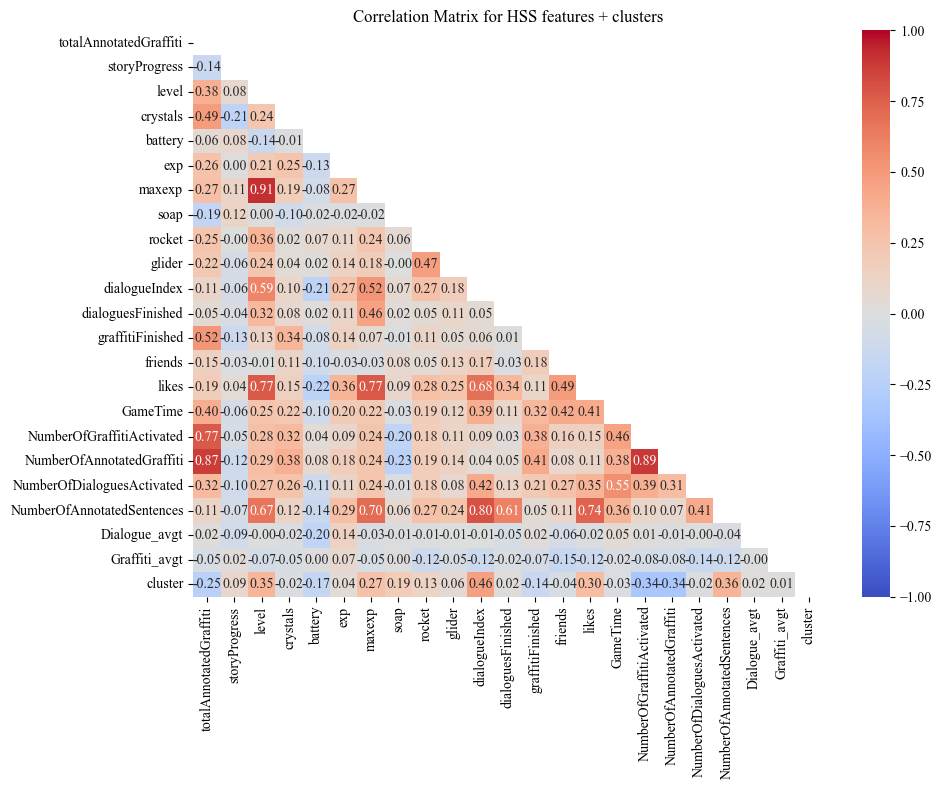

In [2348]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix for HSS features + clusters')
plt.tight_layout()
plt.savefig('Graphs/Correlation_Matrix_for_HSS_features_plus_clusters.png', dpi= 500)
plt.show()

Now some contextual information: what social categories that we know of do the bug-finders belong to?
To obtain this information, I need to identify the users from the clustering dataframe (that does not have the UserID column for ease of use, but all the users are in the same index position as in the general HSS dataframe called df) using the general df, and from there identify their answers in the questionnaires. 

In [2298]:
bug_finders = df[df.index.isin(cl_df.index)][cl_df.cluster == 2]
q_bf = q_data[q_data.UserID.isin(bug_finders.UserID)]

In [2299]:
q_bf.iloc[:,1:].describe(include=['object']).iloc[2:,:]

,Gender,Education,Creender,Creender appropriateness,HSS,HSS appropriateness,RC,RC appropriateness,General engagement,Relationship with researchers,Recommendations
top,Maschio,Medie,Piuttosto interessante,"Sì, erano appropriate per ragazze/i della mia età",Molto interessante,"Sì, era appropriata per ragazze/i della mia età",Piuttosto interessante,"Sì, era appropriata per ragazze/i della mia età",Coinvolgente,Positivo,no
freq,81,103,52,103,81,122,62,117,65,58,33


The bug-finders appreciated the game. 

#### TO UPDATE BASED ON NUMBER OF CLUSTERS Naming the clusters and visualizing their associations with gender and age
To give the clusters some categorical meaning, I suggest to name the first cluster "newbies" (it: "novizi"), as these people have on average the lowest scores in the game. The intermediate cluster could be "gamers" (it: "gamers"), and the bug-finders already have a name (it: "cercatori di bug").

In [2300]:
cl_df.shape[0]
gen_df = df[(df.index.isin(cl_df.index))| (df.UserID.isin(outliers.UserID))]
gen_df['cluster'] = cl_df['cluster']
w = pd.merge(gen_df, q_data, on='UserID', how='left')
w.loc[:, 'Gender'] = ['Preferisco non rispondere' if str(i) == 'nan' else i for i in w['Gender'].tolist()]
R = []
diz = {0:'Novizi', 1:'Gamers', 2:'Cercatori di Bug'}
for u in range(w.shape[0]):
    r=diz[w.iloc[u].cluster]
    R.append(r)
w['cluster'] = R
x_var, y_var = 'cluster', 'Gender'
df_grouped = w.groupby(x_var)[y_var].value_counts(normalize=True).unstack(y_var)

/tmp/ipykernel_23714/1785521676.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeyError: 4.0

In [ ]:
#the following code was adapted from https://stackoverflow.com/questions/64754905/create-100-stacked-bar-chart

In [ ]:
color_palette = ['#f0800e', '#6d5bbf', '#9fdc4c']
plt.figure(figsize=(10, 10))
df_grouped.plot.barh(stacked=True, color=color_palette)
plt.legend(
    bbox_to_anchor=(0.5, 1.02),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=3,
)
N = [37, 160, 113]
r = 0
for ix, row in df_grouped.reset_index(drop=True).iterrows():
    # print(ix, row)
    cumulative = 0
    for element in row:
        rcParams['font.weight'] = 'bold'
        if element == element and element > 0.1:
            plt.text(
                cumulative + element / 2,
                ix,
                f"{int(element * 100)}%",
                va="center",
                ha="center",
                c='white',
                fontsize=14
            )
            cumulative += element
            rcParams['font.weight'] = '10'
    rcParams['font.weight'] = '10'
    plt.text(
        1.05,
        ix,
        f"N = {N[r]}"
    )
    r += 1
             
plt.gca().set_xticklabels([])
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
plt.box(False)
# plt.title('Gender Distribution for clusters')
plt.tight_layout()
plt.savefig('Graphs/Gender_ita_cluster.png', dpi=500)
plt.show()

In [ ]:
colors = list(Color('#ba4dbf').range_to(Color("#ffb60f"),3))
colors = [str(color) for color in colors]
plt.figure(figsize=(10, 8))
sns.violinplot(data=w, hue='cluster', y='Age', cut=0, 
               palette = sns.color_palette(colors),
              linewidth=0.7,
              linecolor='#73686c')
plt.title('Ages of the users by gameplay cluster. Each violin has a boxplot skeleton.')
plt.tight_layout()
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
plt.box(False)
plt.grid(axis='y', linewidth=0.1)
plt.savefig('Graphs/Age_distribution_by_cluster.png', dpi=500)
plt.show()

There are no significant differences between clusters, regarding age. The median, as shown inside each boxplot, is still the same. In terms of density, bug-finders seem to be actually around 13, while the other clusters have different spikes in age, and this diversity comes probably from a bigger sample size (reminder: bug finders are only 37, while other clusters are more than 100 people). We can determine that this game was mostly played by 13 year olds, as they dominate most of the clustered distribution. Let's check for a specific feature that is very correlated with the clusters: game time. 

In [ ]:
colors = list(Color('#ba4dbf').range_to(Color("#ffb60f"),7))
colors = [str(color) for color in colors]
plt.figure(figsize=(10, 8))
sns.violinplot(data=w[w.Gender != 'Preferisco non rispondere'], x='Age',y='GameTime', cut=0,
               hue='Gender',split=True,
               #palette=sns.color_palette(colors),
               linewidth=0.7,
               linecolor='#73686c')
plt.grid(axis='y', linewidth=0.4)
plt.box(False)
plt.legend(title='Genere')
plt.tight_layout()
plt.savefig('Graphs/gametime_distribution_byAge_andGender.png', dpi=500)

On average, 13 year old users were able to play for a handful of minutes more than everyone else. Is this result due to their ability to log in as soon as they got the computer and spend as much time as possible on the game (without mistakenly logging out)? Or is it due to environmental noise and sample size? We'll exclude the sample size doubt in a few computations.

In [ ]:
sns.barplot(w.Age.value_counts(), width=0.95)
plt.title('Age Distribution')
plt.margins(x=0.0)
plt.show()

In [ ]:
# Using the Central Limit Theorem, and assuming that the distribution of Game Time for each age is 
# identically distributed and independent from others, and it's normally distributed, and considering that each sample has size >= 30, I conduct a comparison 
# between mean GameTime for age group = 12 and age group = 13. 
# To reduce the amount of assumptions, I also check for similar variance using Levene's test for equality of variances. 

stat_levene1213, p_value_levene1213 = levene(w[w.Age==12].GameTime, w[w.Age==13].GameTime)
stat_levene1314, p_value_levene1314 = levene(w[w.Age==13].GameTime, w[w.Age==14].GameTime)

t_statistic1213, p_value1213 = ttest_ind(w[w.Age==12].GameTime, w[w.Age==13].GameTime)
t_statistic1314, p_value1314 = ttest_ind(w[w.Age==13].GameTime, w[w.Age==14].GameTime)

In [ ]:
print(f'Comparing the mean GameTime between age groups. {color.BOLD}12{color.END} year olds played for {round(w[w.Age==12].GameTime.mean()//60)} minutes, while {color.BOLD}13{color.END} year olds played for {round(w[w.Age==13].GameTime.mean()//60)} minutes.')
print(f'P-value for Levene\'s test:{p_value_levene1213:.4f}')

print(f'Test Statistic: {color.BOLD}{t_statistic1213:.2f}{color.END}\nP-value for t-statistic: {color.BOLD}{p_value1213:.4f}{color.END}')
print()
print('When conducting the Levene\'s test, if the p-value > significance level, there is no significant difference \nin variances between two groups and the t-test may be conducted assuming equal variance.')
print('Instead, a small p-value for t-test indicates the difference is statistically significant and we should consider the mean between two groups different.')
print()
print(f'Comparing the mean GameTime between age groups. {color.BOLD}13{color.END} year olds played for {round(w[w.Age==13].GameTime.mean()//60)} minutes, while {color.BOLD}14{color.END} year olds played for {round(w[w.Age==14].GameTime.mean()//60)} minutes.')
print(f'P-value for Levene\'s test: {p_value_levene1314:.4f}')

print(f'Test Statistic: {color.BOLD}{t_statistic1314:.2f}{color.END}\nP-value for t-statistic: {color.BOLD}{p_value1314:.4f}{color.END}')

As we can tell from the tests, comparing 13 vs 12 year olds is significant and their variances can be assumed as equivalent. Comparing the 13 vs 14 unfortunately does not meet the variance assumption, but there are ways around this. 

In [ ]:
#Mann-Whitney U test is a non parametric test is used for the unmet variance assumption. 
u_statistic, p_value = mannwhitneyu(w[w.Age==13].GameTime,w[w.Age==14].GameTime)
print(f'U test: {color.BOLD}{u_statistic}{color.END}')
print(f'P-value: {color.BOLD}{p_value:.4f}{color.END}')
print('The U test is a non-parametric test used to assess whether two independent samples come from the same population or have the same distribution. When the p-value is small, the difference is statistically significant, and a high u-statistic is considered a high difference.')

Therefore, we have information: 13 year olds, in this sample, are significantly playing for longer than 12 and 15 year olds, and have the longest play time. 
Information about the tests used can be explained in several sources, as in [this example](https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_nonparametric/bs704_nonparametric_print.html#:~:text=When%20comparing%20two%20independent%20samples,the%20Mann%20Whitney%20U%20test.).

## Modelling behaviour
In the High School Superhero game, a user could choose to play it "by the rules", effectively reducing the harmful dialogues and erasing graffiti (which require crystal collection, the game's currency), or something else: explore the map, ride the scooter. From the data, we may know what did the user do based on the stats at the end of the gameplay.

I have previously displayed the correlations between each feature with the clusters, but what differs for these relationships in terms of strength when we model the features to predict the cluster? 

K-means is the first model that we used to order the users, and it can be used to predict a new observation y (the cluster it belongs to) given new data X (the related features), but it is not easily interpretable why would it be placed in that hyperregion defined as a cluster. 
K-means is a non parametric model and its results can be visualized by unfolding the clusters (and all the observations), or alternatively the centroids of clusters, over the features to establish what features define a cluster's region the most.

In [2301]:
import plotly.express as px

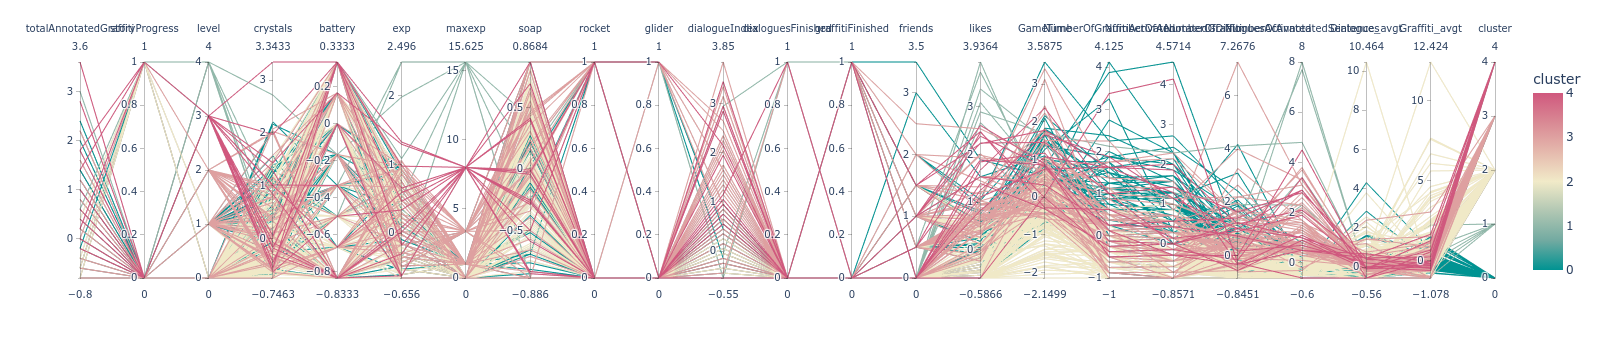

In [2302]:
fig = px.parallel_coordinates(cl_df, color="cluster",
                                dimensions=cl_df.columns.tolist(),
                                color_continuous_scale=px.colors.diverging.Tealrose,
                                color_continuous_midpoint=2)
fig.show()

As expected, it's very confusing: all observations are being displayed, in what's about 307 lines over 23 features. At the end, we see these observations neatly being arranged in the clusters. 
Since the features have been rescaled to avoid the scale of a few features make the clustering more difficult, the scales displayed do not make much sense (e.g. the feature "soap" collected be between 0 and 1 even though its original version was discrete numbers). 

We can display the original scales of the features and the observations now that we've clustered them. 

In [2303]:
df[cols]

,totalAnnotatedGraffiti,storyProgress,level,crystals,battery,exp,maxexp,soap,rocket,glider,...,graffitiFinished,friends,likes,GameTime,NumberOfGraffitiActivated,NumberOfAnnotatedGraffiti,NumberOfDialoguesActivated,NumberOfAnnotatedSentences,Dialogue_avgt,Graffiti_avgt
13,1,1,1,23,1,60.0,100.0,58.0,False,False,...,False,2,140.0,1028.953003,7,3,8,2,1.359144,0.859250
14,6,1,2,13,7,19.0,108.0,43.0,False,False,...,False,0,20.0,1256.866943,12,10,38,1,0.346000,0.728375
15,6,1,2,5,0,99.0,108.0,70.0,False,False,...,False,1,150.0,1154.397095,8,7,8,5,0.678000,0.493750
16,2,1,1,98,7,20.0,100.0,81.0,False,False,...,False,1,50.0,1066.638916,8,2,4,0,NaN,0.856600
17,1,1,1,0,7,0.0,100.0,100.0,False,False,...,False,0,0.0,270.459015,1,1,2,0,NaN,2.390667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,10,0,2,71,7,23.0,108.0,21.0,False,True,...,False,1,90.0,900.582031,14,12,28,4,0.444444,0.262967
422,13,0,2,101,4,43.0,108.0,100.0,False,False,...,True,2,140.0,1024.496094,20,16,29,9,0.338667,0.372333
423,1,0,1,86,1,96.0,100.0,100.0,False,False,...,False,0,88.0,979.994995,7,5,16,7,0.835000,0.888625
424,6,0,3,115,6,42.0,127.0,60.0,False,False,...,False,2,300.0,873.176941,9,8,15,34,0.242825,0.207800


In [2382]:
g.rocket.dtype

dtype('bool')

In [2403]:
list_of_features = []
g = df[df[cols].index.isin(cl_df.index)]
g['cluster'] = cl_df.loc[:,'cluster']
# I am now selecting the top 6 features (most negatively and most positively correlated with clusters)
top6 = corr_target.sort_values(ascending=True)[:3].index.tolist() + corr_target.sort_values(ascending=True)[-3:].index.tolist() + ['cluster']
features = g[cols].dtypes.sort_values().index.tolist() + ['cluster']
for f in features:
    print(f)
    min = round(g[f'{f}'].min()) if g[f'{f}'].dtype != bool else g[f'{f}'].min()
    max = round(g[f'{f}'].max()) if g[f'{f}'].dtype != bool else g[f'{f}'].max()
    res = dict(range=[min, max],
              label=f[:5], values = g[f])
    
    list_of_features.append(res)

glider
rocket
totalAnnotatedGraffiti
NumberOfAnnotatedSentences
NumberOfDialoguesActivated
NumberOfAnnotatedGraffiti
NumberOfGraffitiActivated
friends
dialogueIndex
battery
crystals
level
storyProgress
maxexp
Dialogue_avgt
exp
likes
GameTime
soap
Graffiti_avgt
dialoguesFinished
graffitiFinished
cluster


/tmp/ipykernel_23714/3673113356.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



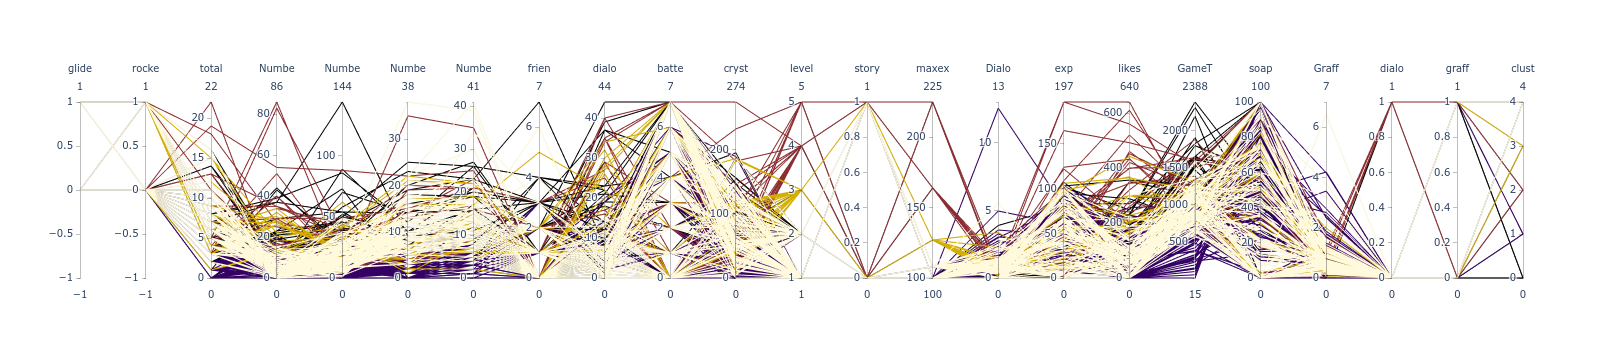

In [2405]:
import plotly.graph_objects as go



fig = go.Figure(data=
    go.Parcoords(
        line = dict(color=g['cluster'],
                    colorscale = 'Electric'),
        dimensions = list_of_features
    ))
# fig = px.parallel_coordinates(g, color="cluster",
#                                 dimensions=cl_df.columns.tolist(),
#                                 color_continuous_scale=px.colors.diverging.Tealrose,
#                                 color_continuous_midpoint=2)
fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)
fig.show()

In [2407]:
g[cols].dtypes.sort_values().index.tolist()

['glider',
 'rocket',
 'totalAnnotatedGraffiti',
 'NumberOfAnnotatedSentences',
 'NumberOfDialoguesActivated',
 'NumberOfAnnotatedGraffiti',
 'NumberOfGraffitiActivated',
 'friends',
 'dialogueIndex',
 'battery',
 'crystals',
 'level',
 'storyProgress',
 'maxexp',
 'Dialogue_avgt',
 'exp',
 'likes',
 'GameTime',
 'soap',
 'Graffiti_avgt',
 'dialoguesFinished',
 'graffitiFinished']

In [ ]:
centroids_only = pd.DataFrame(kmeans.cluster_centers_, columns=g.iloc[1:2, :-1].columns)
centroids_only['cluster'] = [0, 1, 2, 3, 4]

fig = px.parallel_coordinates(centroids_only, color="cluster",
                                dimensions=centroids_only.columns,
                                color_continuous_scale=px.colors.diverging.Tealrose,
                                color_continuous_midpoint=2)
plt.savefig
fig.show()